- https://github.com/AstraZeneca/skywalkR-graph-features

> KR4SL: knowledge graph reasoning for explainable prediction of synthetic lethality 
> - https://doi.org/10.1093/bioinformatics/btad261

- https://github.com/mims-harvard/PrimeKG#dataloader-therapeutics-data-commons

- https://tdcommons.ai/multi_pred_tasks/ppi/

___

List drug names:
- PARP INHIBITOR
    - Olaparib
- ATM INHIBITOR
    - AZD0156
- ATR INHIBITOR
    - AZD6738
- WEE1 INHIBITOR
    - AZD1775
- DNA-PK INHIBITOR
    - AZD7648

In [1]:
import numpy as np 
import pandas as pd
import anndata as ad
import screenpro as scp

from screenpro.load import loadScreenProcessingData, read_adata_pkl

import sys
sys.path.append("/data_gilbert/home/aarab/FunGI")
from search import *

In [2]:
import matplotlib.pyplot as plt

from matplotlib import font_manager as fm
from matplotlib import rcParams

font_files = fm.findSystemFonts(fontpaths=None, fontext='ttf')

for font_file in font_files:
    fm.fontManager.addfont(font_file)

# {f.name for f in matplotlib.font_manager.fontManager.ttflist}

rcParams['font.family'] = ['Arial']

### Get phenotype scores

In [3]:
Ci = read_adata_pkl('datasets/CRISPRi')
Ca_A549 = read_adata_pkl('datasets/CRISPRa_A549')
Ca_k562 = read_adata_pkl('datasets/CRISPRa_k562')

In [4]:
Ci.comparisons

{'gamma': 'gamma',
 'PARPi': 'rho1',
 'DNAPKi': 'rho2',
 'ATMi': 'rho3',
 'ATRi': 'rho4',
 'WEE1i': 'rho5',
 'PARPi+DNAPKi': 'rho6',
 'PARPi+ATMi': 'rho7',
 'PARPi+ATRi': 'rho8',
 'PARPi+WEE1i': 'rho9'}

### Build a single KG

https://github.com/abearab/DDRi/issues/3

In [5]:
from tdc.knowledge_graph import KnowledgeGraph, build_KG

In [6]:
def getTreatmentKG(screen,treatment,perturbation,threshold=10,rep_name='ave_rep1_rep2'):
    gene_score = screen.phenotypes['gene_scores']
    
    df = pd.DataFrame({
        'score':gene_score[screen.comparisons[treatment]][rep_name]['average phenotype of strongest 3'].astype(float),
        'pvalue':gene_score[screen.comparisons[treatment]][rep_name]['Mann-Whitney p-value'].astype(float)
    }).reset_index()
    
    df = scp.phenoScore.ann_score_df(df,threshold=threshold, ctrl_label='pseudo')
    
    df = df[['target','label']].query('label not in ["target_non_hit","pseudo"]').reset_index(drop=True)
    
    kg = build_KG(
        indices = df.index,# a list to assign row names of output data frame
        relation = perturbation, # a list or string to assign values
        display_relation= df.label,# a list or string to assign values

        x_id = treatment,# a list or string to assign values
        x_type = 'Drug',# a list or string to assign values
        x_name = treatment,# a list or string to assign values
        x_source = 'AstraZeneca',# a list or string to assign values

        y_id = df.target,# a list or string to assign values
        y_type = 'gene',# a list or string to assign values
        y_name = df.target,# a list or string to assign values
        y_source = 'NCBI'# a list or string to assign values
    )
    
    return kg

In [7]:
Ci_kg = pd.concat([
    getTreatmentKG(Ci,treatment=t,perturbation='A549_CRISPRi').df 
    for t in list(Ci.comparisons.keys())
]).reset_index(drop=True)

Ca_A549_kg = pd.concat([
    getTreatmentKG(Ca_A549,treatment=t,perturbation='A549_CRISPRa',rep_name='Rep1').df
    for t in list(Ca_A549.comparisons.keys())
]).reset_index(drop=True)

Ca_k562_kg = pd.concat([
    getTreatmentKG(Ca_k562,treatment=t,perturbation='K562_CRISPRa').df
    for t in list(Ca_k562.comparisons.keys())
]).reset_index(drop=True)

In [8]:
DDRi_screens_kg = pd.concat([
    Ci_kg,
    Ca_A549_kg,
    Ca_k562_kg,
]).reset_index(drop=True)

DDRi_screens_kg = KnowledgeGraph(DDRi_screens_kg)

In [9]:
DDRi_screens_kg.df.to_csv('DDRi_screens_kg.csv',index=False)

___

In [10]:
DDRi_screens_A549_CRISPRi_kg = DDRi_screens_kg.copy()

DDRi_screens_A549_CRISPRi_kg.run_query('relation=="A549_CRISPRi"')

DDRi_screens_A549_CRISPRi_kg.df.to_csv('DDRi_screens_A549_CRISPRi_kg.csv',index=False)

___

In [11]:
DDRi_screens_rho_kg = DDRi_screens_A549_CRISPRi_kg.copy()

DDRi_screens_rho_kg.run_query('x_id!="gamma"')

In [12]:
DDRi_screens_rho_sen_kg = DDRi_screens_rho_kg.copy()

DDRi_screens_rho_sen_kg.run_query('display_relation=="sensitivity_hit"')

### Annotated graph to highlight PRDX1

- color `edge` by rho score direction 
- weight`edge` by rho score values
- circle gene `nodes` and square treatment nodes
- size gene `nodes` give a confidence value from the p-values
    - maybe average of `-log10(p-values)`
    - https://stats.stackexchange.com/questions/78596/when-combining-p-values-why-not-just-averaging
- export data for cytoscape visualization

#### 
https://github.com/cytoscape/py2cytoscape

In [13]:
import random
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
import igraph as ig

In [14]:
def build_graph(kg,verbose=True):

    gr = ig.Graph.TupleList(
        kg.df[['x_id','y_id']].itertuples(index=False), 
        directed=False, weights=False
    )
    
    gr.vs['nodeType'] = [
        'drug' if node in kg.df.x_name.unique() else 'gene' 
        for node in gr.vs['name']
    ]
    
    if verbose: get_graph_features(gr)
    
    return gr

In [15]:
def plot_betweenness(g, ax, cax1, cax2):
    '''Plot vertex/edge betweenness, with colorbars

    Args:
        g: the graph to plot.
        ax: the Axes for the graph
        cax1: the Axes for the vertex betweenness colorbar
        cax2: the Axes for the edge betweenness colorbar
    '''
    vertex_betweenness = g.betweenness()
    edge_betweenness = g.edge_betweenness()

    # Rescale betweenness to be between 0.0 and 1.0
    scaled_vertex_betweenness = ig.rescale(vertex_betweenness, clamp=True)
    scaled_edge_betweenness = ig.rescale(edge_betweenness, clamp=True)
    print(f"vertices: {min(vertex_betweenness)} - {max(vertex_betweenness)}")
    print(f"edges: {min(edge_betweenness)} - {max(edge_betweenness)}")

    # Define mappings betweenness -> color
    cmap1 = LinearSegmentedColormap.from_list("vertex_cmap", ["pink", "indigo"])
    cmap2 = LinearSegmentedColormap.from_list("edge_cmap", ["lightblue", "midnightblue"])

    # Plot graph
    g.vs["color"] = [cmap1(betweenness) for betweenness in scaled_vertex_betweenness]

    d_thr = 9
    g.vs["frame_color"] = [
        'red' if d >= d_thr and nType != 'drug' else 'black' for d,nType in zip(g.vs.degree(),g.vs['nodeType'])
    ]
    
#     frame_colors = []
#     for d,name,nType in zip(g.vs.degree(),g.vs['name'], g.vs['nodeType']):
#         if d >= d_thr and nType != 'drug':
#             frame_colors.append('red')
#         elif d < d_thr and nType != 'drug':
#             frame_colors.append('black')
#         elif '+' in name and nType == 'drug':
#             frame_colors.append('green')
#         else:
#             frame_colors.append('blue')
            
#     g.vs["frame_color"] = frame_colors
    
    
#     g.vs["frame_width"] = [
#         3 if d >= d_thr and nType != 'drug' else 1 for d,nType in zip(g.vs.degree(),g.vs['nodeType'])
#     ]
    
    s_scale = 0.05
    g.vs["size"]  = [12 * s_scale if d > 10 else d * s_scale for d in g.vs.degree()]
    g.vs['shape'] = ['rectangle' if nType is 'drug' else 'circle' for nType in gr.vs['nodeType']]
    g.vs['label'] = [name if d > 10 else '' for d,name in zip(g.vs.degree(), g.vs['name'])]

    g.es["size"] = [betweenness for betweenness in scaled_edge_betweenness]
    g.es["color"] = [cmap2(betweenness) for betweenness in scaled_edge_betweenness]
    g.es["width"] = ig.rescale(edge_betweenness, (0.5, 1.0))

    # g.layout_fruchterman_reingold(niter=10000)
    # g.layout_reingold_tilford_circular(mode='in')
    
    ig.plot(
        g,
        target=ax,
        layout="fruchterman_reingold",
        keep_aspect_ratio=True,
    )

    # Color bars
    norm1 = ScalarMappable(norm=Normalize(0, max(vertex_betweenness)), cmap=cmap1)
    norm2 = ScalarMappable(norm=Normalize(0, max(edge_betweenness)), cmap=cmap2)
    plt.colorbar(norm1, cax=cax1, orientation="horizontal", label='Vertex Betweenness')
    plt.colorbar(norm2, cax=cax2, orientation="horizontal", label='Edge Betweenness')
    
    return g

In [16]:
gr0 = build_graph(DDRi_screens_rho_sen_kg)

IGRAPH UN-- 1139 2723 -- 
+ attr: name (v), nodeType (v) 

Number of vertices in the graph: 1139
Number of edges in the graph 2723
Is the graph directed: False
Maximum degree in the graph: 466
Node name with Maximum degree: ['WEE1i']


In [17]:
gr1 = gr0.copy()

## filter by degree
# https://codereview.stackexchange.com/questions/284246/deletion-of-nodes-of-degree-1-from-a-python-igraph-graph
gr1.delete_vertices({v for v in gr1.vs.select(_degree_le=1)})

get_graph_features(gr1)

IGRAPH UN-- 701 2285 -- 
+ attr: name (v), nodeType (v) 

Number of vertices in the graph: 701
Number of edges in the graph 2285
Is the graph directed: False
Maximum degree in the graph: 391
Node name with Maximum degree: ['DNAPKi']


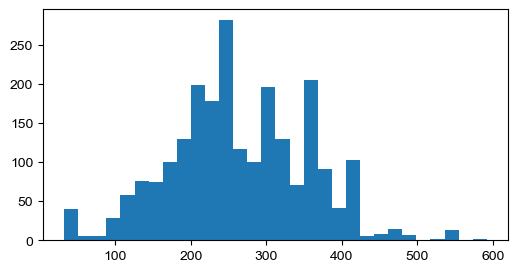

In [656]:
plt.figure(figsize=(6, 3))
plt.hist(gr1.edge_betweenness(),bins=30)
plt.show()

In [657]:
# gr = gr1.es.subgraph([
#     (e < pd.Series(gr1.edge_betweenness()).quantile(.1)) |
#     (e > pd.Series(gr1.edge_betweenness()).quantile(.9)) 
#     for e in gr1.edge_betweenness()
# ])
gr = gr1.copy()

In [658]:
[n for d,n in zip(gr.degree(),gr.vs['name']) if d >= 9 and 'i' not in n]

['CDK12', 'PRDX1', 'RAD9A', 'RFC5']

In [659]:
gr = gr.simplify()

vertices: 1.2264790067485558 - 63657.79975374474
edges: 32.203585631218246 - 591.782674966226


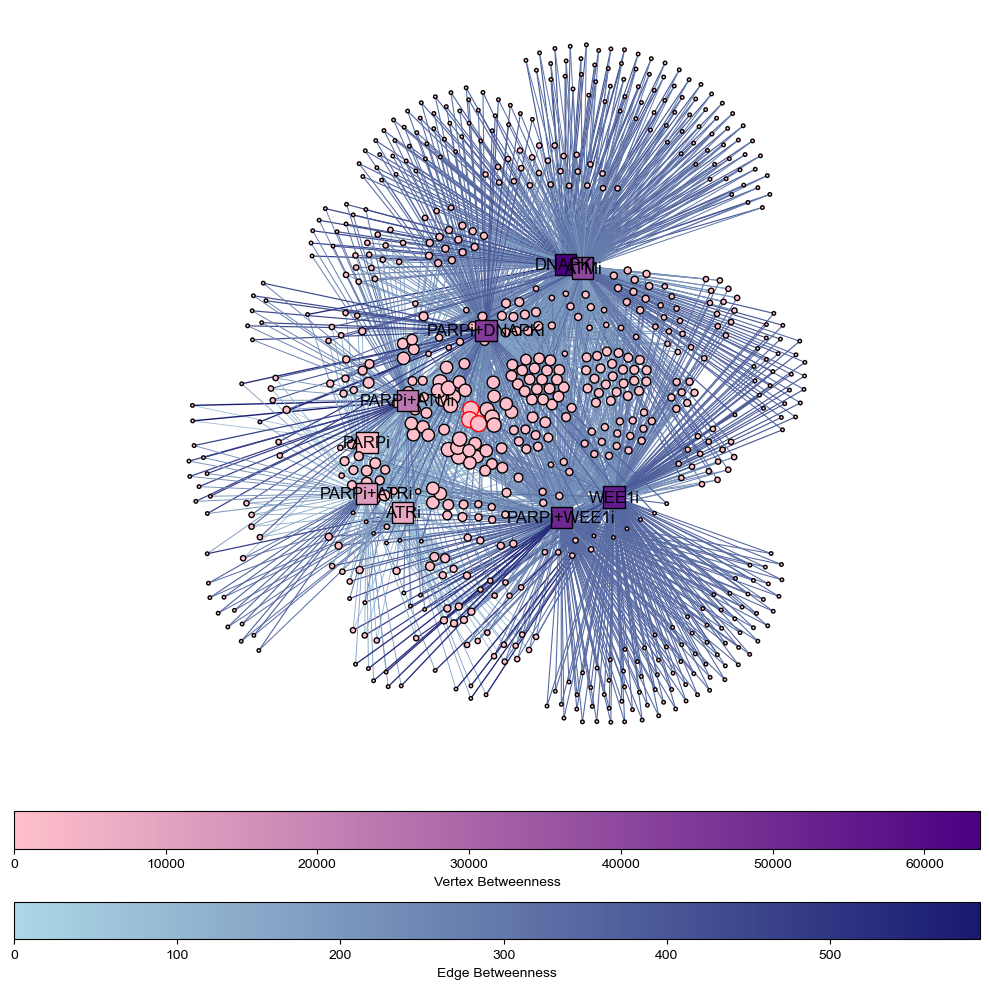

In [660]:
fig, axs = plt.subplots(
    3, 1,
    figsize=(10, 10),
    gridspec_kw={"height_ratios": (20, 1, 1)},
)

gr_plot = plot_betweenness(gr, *axs)

fig.tight_layout(h_pad=1)
plt.savefig("test.pdf")
plt.show()

In [333]:
# cyto = ig.drawing.graph.CytoscapeGraphDrawer()

# cyto.draw(graph=gr_plot)

In [347]:
from pyvis.network import Network

In [340]:
nt = Network('500px', '500px',notebook=True)

In [341]:
nt.from_nx(gr_plot.to_networkx())

In [458]:
# nt.show('test.html')

### Drug KG

In [45]:
# help(data)

In [47]:
primekg_subgr_1 = data.copy()

In [49]:
primekg_subgr_1.run_query('(x_name == "Olaparib" | y_name == "Olaparib")')

In [50]:
primekg_subgr_1.df.groupby('display_relation').size()

display_relation
enzyme                        6
indication                   54
synergistic interaction    2012
target                        6
transporter                   4
dtype: int64

In [28]:
# drug_feature = data.get_features(feature_type = 'drug')

# data.df.query('x_name == "Decitabine" | y_name == "Decitabine"').groupby('display_relation').size()

# data.df.query('(x_name == "Decitabine" | y_name == "Decitabine")&(display_relation == "synergistic interaction")')

# data.df.query('(x_name == "Decitabine" | y_name == "Decitabine")&(x_name == "Decitabine" | y_name == "Decitabine")&(display_relation == "synergistic interaction")')

In [31]:
# data.df.query('(x_name == "Olaparib" | y_name == "Olaparib")&(display_relation == "indication")')

In [34]:
# data.get_node_list(node_type='drug')

In [40]:
help(data.run_query)

Help on method run_query in module tdc.knowledge_graph:

run_query(query) method of tdc.knowledge_graph.KnowledgeGraph instance
    build subgraph using given query



In [41]:
data.run_query('(x_name == "Olaparib" | y_name == "Olaparib")&(display_relation == "target")')

In [42]:
datadata.copy()

In [36]:
data.df.query('(x_name == "Olaparib" | y_name == "Olaparib")&(display_relation == "transporter")')

,relation,display_relation,x_id,x_type,x_name,x_source,y_id,y_type,y_name,y_source
344703,drug_protein,transporter,DB09074,drug,Olaparib,DrugBank,5243,gene/protein,ABCB1,NCBI
345213,drug_protein,transporter,DB09074,drug,Olaparib,DrugBank,9429,gene/protein,ABCG2,NCBI
5731503,drug_protein,transporter,5243,gene/protein,ABCB1,NCBI,DB09074,drug,Olaparib,DrugBank
5732013,drug_protein,transporter,9429,gene/protein,ABCG2,NCBI,DB09074,drug,Olaparib,DrugBank


In [88]:
data.df.query('(x_name == "Olaparib" | y_name == "Olaparib")&(display_relation == "enzyme")')

,relation,display_relation,x_id,x_type,x_name,x_source,y_id,y_type,y_name,y_source
322973,drug_protein,enzyme,DB09074,drug,Olaparib,DrugBank,1577,gene/protein,CYP3A5,NCBI
324462,drug_protein,enzyme,DB09074,drug,Olaparib,DrugBank,1576,gene/protein,CYP3A4,NCBI
326432,drug_protein,enzyme,DB09074,drug,Olaparib,DrugBank,1555,gene/protein,CYP2B6,NCBI
5709773,drug_protein,enzyme,1577,gene/protein,CYP3A5,NCBI,DB09074,drug,Olaparib,DrugBank
5711262,drug_protein,enzyme,1576,gene/protein,CYP3A4,NCBI,DB09074,drug,Olaparib,DrugBank
5713232,drug_protein,enzyme,1555,gene/protein,CYP2B6,NCBI,DB09074,drug,Olaparib,DrugBank


In [ ]:
# g = data.to_nx()
# g = ig.Graph.from_networkx(g)

this is problematic – https://github.com/mims-harvard/TDC/blob/6af2a41679a0699446ad627be8051504548e86fa/tdc/resource/primekg.py#L30

In [107]:
# help(ig.Graph.TupleList)

___

In [3]:
import igraph as ig

In [4]:
# def convert_graph_to_dataframe(G):
#     # https://igraph.discourse.group/t/convert-graph-object-to-dataframe/575
#     node_df = pd.DataFrame({attr: G.vs[attr] for attr in G.vertex_attributes()})
#     edge_df = pd.DataFrame({attr: G.es[attr] for attr in G.edge_attributes()})
    
#     return edge_df, node_df

In [55]:
# help(filter_graph_by_weight)

In [56]:
# help(run_bfs)

In [7]:
def build_graph(df,verbose=True):

    out = ig.Graph.TupleList(df.itertuples(index=False), directed=False, weights=True)

    if verbose: get_graph_features(out)

    return out

In [8]:
def filter_graph_by_nodes_BFS(G, nodes, max_distance=1, verbose=True):
    """filter graph `G` by running BFS for given nodes
    """
    bfs = []
    for node in nodes:
        for distance in range(1, max_distance + 1):
            bfs = bfs + run_bfs(G, node, distance=distance)
    
    outG = G.vs.select(name_in=bfs + nodes).subgraph()
    
    if verbose: get_graph_features(outG)
    
    return outG

In [9]:
def plot_graph(G, geneset=None, geneset2=None, layout="kk", b1=500, b2=500):
    """visualising graph data
    """
    G.vs["color"] = ["lightgray" for vertex in G.vs] 

    if geneset: 
        for gene in geneset:
            G.vs[[i for i, x in enumerate(G.vs['name']) if x == gene][0]]['color'] = 'yellow'
            
    if geneset2: 
        for gene in geneset2:
            G.vs[[i for i, x in enumerate(G.vs['name']) if x == gene][0]]['color'] = "lightblue"

    return ig.plot(
        G,
        layout=G.layout(layout),
        vertex_label=G.vs["name"],
        vertex_color=G.vs["color"],
        vertex_label_size=6, 
        vertex_size=35,
        edge_arrow_size = 0.5,
        edge_arrow_width = 2,
        bbox=(b1, b2), margin=60,
    )

___

In [10]:
%load_ext rpy2.ipython

https://users.dimi.uniud.it/~massimo.franceschet/R/communities.html

https://kateto.net/netscix2016.html

In [11]:
%%R
library(igraph)
library(tidyverse)

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union




── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%--%()      masks igraph::%--%()
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::simplify()      masks igraph::simplify()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


___

In [177]:
g = ig.Graph.TupleList(
    data.df[['x_id','y_id','display_relation','x_type','x_name','y_type','y_name']].itertuples(index=False),
    edge_attrs=['display_relation','x_type','x_name','y_type','y_name'],
    directed=True, weights=False
)

In [178]:
get_graph_features(g)

IGRAPH DN-- 135010 8100498 -- 
+ attr: name (v), display_relation (e), x_name (e), x_type (e), y_name (e), y_type (e) 

Number of vertices in the graph: 135010
Number of edges in the graph 8100498
Is the graph directed: True
Maximum degree in the graph: 34998
Node name with Maximum degree: []


In [179]:
g_PARPi = filter_graph_by_nodes_BFS(g,['DB09074'],max_distance=2)

IGRAPH DN-- 11252 3258577 -- 
+ attr: name (v), display_relation (e), x_name (e), x_type (e), y_name (e), y_type (e) 

Number of vertices in the graph: 11252
Number of edges in the graph 3258577
Is the graph directed: True
Maximum degree in the graph: 5200
Node name with Maximum degree: ['DB00908']


In [180]:
g_PARPi_edge_df = g_PARPi.get_edge_dataframe()

___

In [181]:
d = g_PARPi_edge_df

In [182]:
%%R -i d
g = graph_from_data_frame(d, directed = FALSE, vertices = NULL)
g = igraph::simplify(g)

# V(g)$color <- l[V(g)$name,]
# E(g)$width <- E(g)$weight 

In [ ]:
%%R
V(g)$name

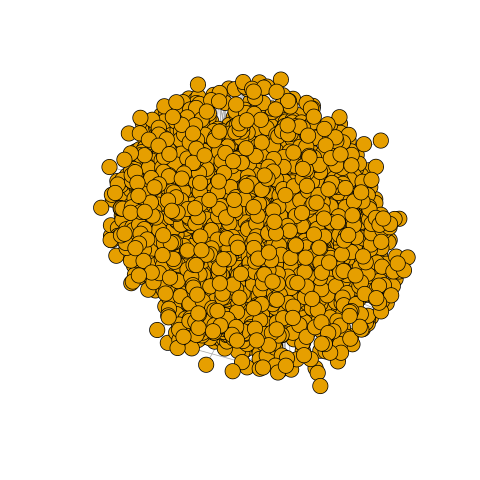

In [185]:
%%R
coords = layout_with_fr(g)

# plot the graph
plot(g, layout=coords, 
     vertex.label=NA, 
     # vertex.color =l[V(g)$name,],
     vertex.size=10,
    )

### Get phenotype scores

In [155]:
Ci_adata = read_adata_pkl('datasets/CRISPRi')
Ca_A549_adata = read_adata_pkl('datasets/CRISPRa_A549')
Ca_k562_adata = read_adata_pkl('datasets/CRISPRa_k562')

In [156]:
def get_annotated_score_df(adata,score,level,threshold):
    if level == 'transcript':
        df = adata.transcript_scores[score]['ave_rep1_rep2'][[
            'average phenotype of strongest 3',
            'Mann-Whitney p-value',
        ]].reset_index('gene').reset_index(drop=True).copy()
    
    elif level == 'gene':
        df = adata.gene_scores[score]['ave_rep1_rep2'][[
            'average phenotype of strongest 3',
            'Mann-Whitney p-value',
        ]].reset_index('gene').copy()
        
    df = screenpro.phenoScore.ann_score_df(df, ctrl_label='pseudo',threshold=threshold)
    
    return df

In [157]:
screenpro.phenoScore.ann_score_df

<function screenpro.phenoScore.ann_score_df(df_in, up_hit='resistance_hit', down_hit='sensitivity_hit', ctrl_label='non-targeting', threshold=10)>

In [158]:
threshold = 2

In [159]:
rho_dict = dict([
    (treat,get_annotated_score_df(Ci_adata,score,'gene',threshold = threshold).set_index('target')) for treat, score in Ci_adata.comparisons.items()
])

In [160]:
rho_df = pd.concat(dict([(treat,rho.score) for treat, rho in rho_dict.items()]),axis=1)
# rho_df = pd.concat(rho_dict,axis=1)

rho_label = pd.concat(dict([(treat,rho.label) for treat, rho in rho_dict.items()]),axis=1)

In [161]:
rho_bin = pd.DataFrame(0,index=rho_label.index,columns=rho_label.columns)

rho_bin = (rho_label.isin(['sensitivity_hit']) * -1) + (rho_label.isin(['resistance_hit']) * 1)

# rho_bin = rho_bin[~rho_bin.eq(0).sum(axis=1).eq(9)]

___

In [165]:
data.df.query('x_name == "PRDX1"')

,relation,display_relation,x_id,x_type,x_name,x_source,y_id,y_type,y_name,y_source
2467,protein_protein,ppi,5052,gene/protein,PRDX1,NCBI,55692,gene/protein,LUC7L,NCBI
4249,protein_protein,ppi,5052,gene/protein,PRDX1,NCBI,117157,gene/protein,SH2D1B,NCBI
5540,protein_protein,ppi,5052,gene/protein,PRDX1,NCBI,23512,gene/protein,SUZ12,NCBI
10167,protein_protein,ppi,5052,gene/protein,PRDX1,NCBI,246184,gene/protein,CDC26,NCBI
28299,protein_protein,ppi,5052,gene/protein,PRDX1,NCBI,9585,gene/protein,KIF20B,NCBI
...,...,...,...,...,...,...,...,...,...,...
5729251,drug_protein,target,5052,gene/protein,PRDX1,NCBI,DB14487,drug,Zinc acetate,DrugBank
5729252,drug_protein,target,5052,gene/protein,PRDX1,NCBI,DB14533,drug,Zinc chloride,DrugBank
5729253,drug_protein,target,5052,gene/protein,PRDX1,NCBI,DB14548,drug,"Zinc sulfate, unspecified form",DrugBank
6496314,exposure_protein,interacts with,5052,gene/protein,PRDX1,NCBI,D001151,exposure,Arsenic,CTD


In [288]:
get_graph_features(g_PARPi)

IGRAPH DN-- 11252 3258577 -- 
+ attr: name (v), display_relation (e), x_name (e), x_type (e), y_name (e), y_type (e) 

Number of vertices in the graph: 11252
Number of edges in the graph 3258577
Is the graph directed: True
Maximum degree in the graph: 5200
Node name with Maximum degree: ['DB00908']


In [285]:
g_PARPi_prdx1 = filter_graph_by_nodes_BFS(g_PARPi,['5052'],max_distance=2)

IGRAPH DN-- 4587 2223894 -- 
+ attr: name (v), display_relation (e), x_name (e), x_type (e), y_name (e), y_type (e) 

Number of vertices in the graph: 4587
Number of edges in the graph 2223894
Is the graph directed: True
Maximum degree in the graph: 4451
Node name with Maximum degree: ['DB00363']


In [ ]:
plot_graph(
    g_PARPi_prdx1,
    geneset = ['5052'],
    geneset2= ['DB09074']
)

___

In [187]:
d = g_PARPi_prdx1.get_edge_dataframe()

In [188]:
%%R -i d
# ,s,l
g = graph_from_data_frame(d, directed = FALSE, vertices = NULL)
g = igraph::simplify(g)

# V(g)$color <- l[V(g)$name,]
# E(g)$width <- E(g)$weight 

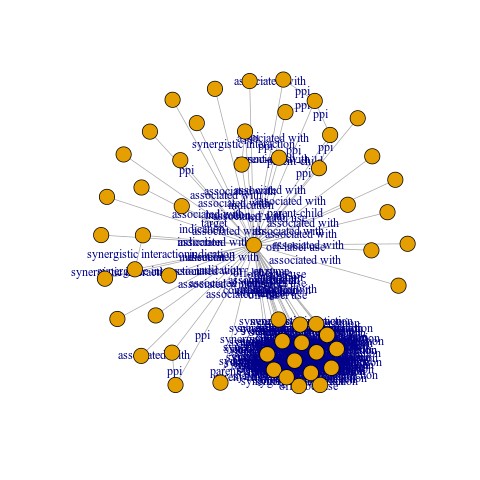

In [190]:
%%R
coords = layout_with_fr(g)

# plot the graph
plot(g, layout=coords, 
     vertex.label=NA, 
     # vertex.color =l[V(g)$name,],
     vertex.size=10,
     edge.label = d$display_relation
    )

___

### geneset!

In [18]:
gesa_res = pd.concat(dict([
    (treat, pd.read_excel('results/go_gsea.xlsx',index_col=0,header=0,sheet_name=f'CRISPRi {treat}')['es'])
    for treat in Ci_adata.comparisons.keys()
]),axis=1).fillna(0)

### PCC graph
Pearson’s correlation coefficient (PCC) `gene-gene-cor` graph

> #### A Genetic Map of the Response to DNA Damage in Human Cells
> The similarity in profiles of genes having related function (e.g.,
XRCC4 and LIG4 or ERCC6 and ERCC8) prompted us to undertake similarity profiling based on their Pearson correlation coefficient (PCC). This allowed us to build a network where genes are
nodes, and their edges are constrained by their PCC values

> - https://doi.org/10.1016/j.cell.2020.05.040


In [19]:
# exclude neg-ctrl signal
rho_df_1 = rho_df[~rho_df.index.str.contains('pseudo')].copy()

# exclude genes if they are non-hit in all screens
rho_df_2 = rho_df_1[~rho_label[~rho_df.index.str.contains('pseudo')].eq('target_non_hit').sum(axis=1).eq(9)].copy()

# get gene level corr values
rho_target_corr = rho_df_2.T.corr()
rho_target_corr.columns.name = None

In [20]:
# make the graph table
rho_target_corr_gr_table0 = rho_target_corr.reset_index().melt(
    id_vars=['target'],var_name=['target2']
)

<div class="alert alert-block alert-info"> <b>NOTE</b> `target` and `target2` are target genes from a single targeting CRISPR platform. These are just named for Pearson’s correlation coefficient (PCC) graph analysis. </div>

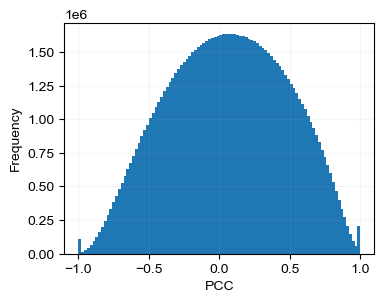

In [21]:
rho_target_corr_gr_table0.value.hist(bins=100,figsize=(4,3))
plt.xlabel('PCC')
plt.ylabel('Frequency')
plt.grid('off', alpha=0.1) 
plt.show() 

#### filter

In [22]:
rho_target_corr_gr_table = rho_target_corr_gr_table0.query("value > 0.9 & target != target2").reset_index(drop=True)

In [23]:
# rho_target_corr_gr_table.value.hist(bins=100,figsize=(4,3))
# plt.xlabel('PCC')
# plt.ylabel('Frequency')
# plt.grid('off', alpha=0.1) 
# plt.show() 

In [24]:
rho_target_corr_gr = build_graph(rho_target_corr_gr_table)

IGRAPH UNW- 10035 702798 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 10035
Number of edges in the graph 702798
Is the graph directed: False
Maximum degree in the graph: 13146
Node name with Maximum degree: ['ANLN', 'GAR1', 'NOP2', 'POLR2H', 'RPS13', 'UTP20']


In [25]:
help(filter_graph_by_weight)

Help on function filter_graph_by_weight in module search:

filter_graph_by_weight(G, weight_thr, side, verbose=True)
    subset graph by weight threshold



In [26]:
rho_target_corr_gr_prdx1 = filter_graph_by_geneset(
    rho_target_corr_gr,
    geneset=['PRDX1'],
    max_distance=1
)

IGRAPH UNW- 30 382 -- 
+ attr: name (v), weight (e) 

Number of vertices in the graph: 30
Number of edges in the graph 382
Is the graph directed: False
Maximum degree in the graph: 58
Node name with Maximum degree: ['PRDX1']


In [27]:
# plot_graph(
#     rho_target_corr_gr_prdx1.simplify(),
#     geneset=['PRDX1'],
#     # geneset2 = list(set(rho_phenotypes.vs['name']) - set(['ctrlcontext']) ),
#     layout='kk', b1=600,b2=450)

___

In [199]:
keep = rho_target_corr_gr_prdx1.vs['name']

In [288]:
d = rho_target_corr_gr_table.query(f'target in {keep} and target2 in {keep}').reset_index(drop=True)
d.columns = ['V1','V2','weight']

### PARPi

In [310]:
treat = 'PARPi+WEE1i'

In [311]:
s = rho_df.loc[keep,[treat]].fillna(0).abs()

In [312]:
l = rho_label.loc[keep,[treat]].replace({treat: {
    'target_non_hit': 'grey30', 
    'resistance_hit': '#de2d26', 
    'sensitivity_hit': "#3182bd", 
}}).astype(str)

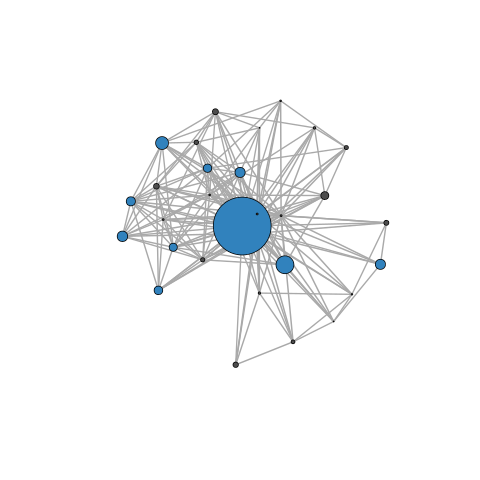

In [317]:
%%R -i d,s,l
g = graph_from_data_frame(d, directed = FALSE, vertices = NULL)
g = igraph::simplify(g)

V(g)$color <- l[V(g)$name,]
E(g)$width <- E(g)$weight 

coords = layout_with_fr(g)

# plot the graph
plot(g, layout=coords, 
     vertex.label=NA, 
     vertex.color =l[V(g)$name,],
     vertex.size=abs(s[V(g)$name,] * 20)
    )

In [293]:
%%R
is_weighted(g)

[1] TRUE


___

In [172]:
# %%R 
# c1 = cluster_optimal(g)
# # modularity(c1)

In [233]:
%%R
c2 = cluster_leading_eigen(g)

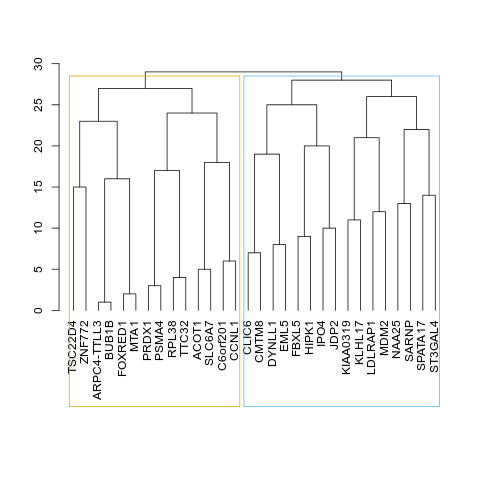

In [259]:
%%R
igraph::plot_dendrogram(c2)

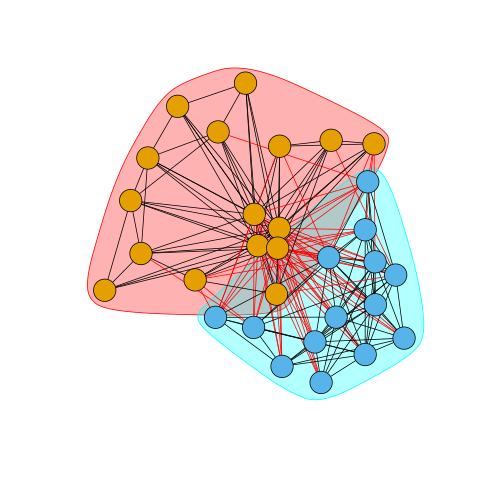

In [260]:
%%R 
plot(c2, g, 
     layout=coords, 
     vertex.label=NA, 
     vertex.color =l[V(g)$name,],
     # vertex.size=abs(s[V(g)$name,] * 20)
    )

### 
<!-- GTP graph -->
`Gene-Treatment-PhenotypeScore` wighted graph

___
build graph

In [ ]:
# gr_table = pd.concat([
#     rho_df.reset_index().melt(id_vars=['target'],value_name='score',var_name='treatment').set_index(['target','treatment']),
#     rho_label.reset_index().melt(id_vars=['target'],var_name='treatment',value_name='label').set_index(['target','treatment'])
# ],axis=1).query('label != "pseudo" and label != "target_non_hit"')

In [ ]:
# gr = build_graph(gr_table.drop(columns='label').reset_index())

___
combine

In [ ]:
# keep = rho_target_corr_gr_prdx1.vs['name']

In [ ]:
# d1 = rho_target_corr_gr_table.query(f'target in {keep} and target2 in {keep}').reset_index(drop=True)
# d1.columns = ['col_1','col_2','value']
# d1['edgeType'] = 'PCC'

# d2 = gr_table.drop(columns='label').reset_index().query(f'target in {keep}').reset_index(drop=True)
# d2.columns = ['col_1','col_2','value']
# d2['edgeType'] = 'GTP'

# d = pd.concat([d1,d2],axis=0).reset_index(drop=True)

In [ ]:
# %%R -i d

# d %>% head

In [ ]:
# %%R
# g = graph_from_data_frame(d, directed = FALSE, vertices = NULL)
# g = igraph::simplify(g)

In [ ]:
# %%R
# coords = layout_with_fr(g)
# # plot the graph
# plot(igraph::simplify(g), layout=coords, vertex.label=NA, vertex.size=10)

In [ ]:
# %%R 
# c1 = cluster_optimal(g)
# # modularity(c1)

In [ ]:
# %%R
# c2 = cluster_leading_eigen(g)

In [ ]:
# %%R
# igraph::plot_dendrogram(c2)

In [ ]:
# %%R 
# plot(c2, g, layout=coords, vertex.color=membership(c1),vertex.label=NA, vertex.size=10)

In [ ]:
# %%R
# plot(g, vertex.color=membership(c2), layout=coords)

# 

In [ ]:
%%R
sessionInfo()

In [19]:
from watermark import watermark
print(
    watermark()
)
print('_'*80)
print(
    watermark(iversions=True, globals_=globals())
)

Last updated: 2023-08-03T13:09:50.628633-07:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

________________________________________________________________________________
pandas: 2.0.3

